<a href="https://colab.research.google.com/github/Edison299792458/TMBA/blob/main/%E5%8F%B0%E6%8C%87%E5%B8%83%E6%9E%97%E5%A4%9A%E6%A8%A3%E6%9C%AC%E5%85%A7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd           
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time

plt.style.use('ggplot')

In [ ]:
from google.colab import drive                                          
import pandas as pd
drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TWF_Futures_Minute_Trade.txt")
df

Mounted at /content/gdrive


,Date,Time,Open,High,Low,Close,TotalVolume
0,2009/1/5,08:46:00,4722.0,4745.0,4714.0,4727.0,1493
1,2009/1/5,08:47:00,4727.0,4728.0,4711.0,4716.0,608
2,2009/1/5,08:48:00,4713.0,4720.0,4713.0,4716.0,400
3,2009/1/5,08:49:00,4717.0,4722.0,4715.0,4718.0,457
4,2009/1/5,08:50:00,4719.0,4721.0,4718.0,4719.0,233
...,...,...,...,...,...,...,...
1971251,2022/5/23,09:10:00,16210.0,16216.0,16206.0,16214.0,452
1971252,2022/5/23,09:11:00,16215.0,16215.0,16207.0,16210.0,224
1971253,2022/5/23,09:12:00,16210.0,16220.0,16207.0,16218.0,478
1971254,2022/5/23,09:13:00,16218.0,16220.0,16212.0,16218.0,240


In [ ]:
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour)
df.head(3)

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8


In [ ]:
rule = '60T'

Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)

d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)
df_Morning.head()

,open,high,low,close,volume
2009-01-05 08:45:00,4722.0,4797.0,4692.0,4758.0,27508
2009-01-05 09:45:00,4759.0,4767.0,4710.0,4732.0,15701
2009-01-05 10:45:00,4732.0,4733.0,4634.0,4670.0,25172
2009-01-05 11:45:00,4672.0,4688.0,4636.0,4680.0,13241
2009-01-05 12:45:00,4680.0,4698.0,4656.0,4670.0,16247


In [ ]:
df_Morning['Hour'] = df_Morning.index.map(lambda x: x.hour)

In [ ]:
trainData = df_Morning[(df_Morning.index >= '2011-01-01 00:00:00') & (df_Morning.index <= '2019-12-31 00:00:00')].copy()
testData = df_Morning[(df_Morning.index >= '2020-1-1 00:00:00') & (df_Morning.index <= '2022-5-22 00:00:00')].copy()

In [ ]:
fund = 1000000
feePaid = 600
length = 3
NumStd = 1.5
K = 0.04

# trainData['H'] = trainData['high'].shift(1).rolling(window=length, center=False).max()
# trainData['L'] = trainData['low'].shift(1).rolling(window=length, center=False).min()
trainData['MA'] = trainData['close'].rolling(window=3, center=False).mean()
trainData['nSTD'] = trainData['close'].rolling(window=12, center=False).std()
trainData['STD']=(trainData['nSTD']/trainData['MA'])
trainData['MA200'] = trainData['close'].rolling(window=30, center=False).mean()
trainData['upLine'] = trainData['MA200'] + NumStd*trainData['nSTD']
trainData['downLine'] = trainData['MA200'] - NumStd*trainData['nSTD']
trainData['MA200'] = trainData['close'].rolling(window=30, center=False).mean()
trainData.tail(3)

trainData['MA15'] = trainData['close'].rolling(window=15, center=False).mean()

trainData['MA180'] = trainData['close'].rolling(window=30, center=False).mean()
trainData['nSTD180'] = trainData['MA180'].rolling(window=3, center=False).mean()
trainData['sb']=trainData['nSTD180']-trainData['MA180']
trainData['STD180']=(trainData['nSTD180']/trainData['MA180'])
trainData.tail(3)

,open,high,low,close,volume,Hour,MA,nSTD,STD,MA200,upLine,downLine,MA15,MA180,nSTD180,sb,STD180
2019-12-30 10:45:00,12096.0,12108.0,12089.0,12104.0,6348,10,12103.666667,46.359187,0.003830,12027.933333,12097.472114,11958.394552,12057.533333,12027.933333,12025.288889,-2.644444,0.999780
2019-12-30 11:45:00,12103.0,12110.0,12099.0,12107.0,3898,11,12102.666667,42.984405,0.003552,12031.333333,12095.809941,11966.856726,12064.600000,12031.333333,12028.177778,-3.155556,0.999738
2019-12-30 12:45:00,12108.0,12109.0,12065.0,12069.0,17832,12,12093.333333,37.204187,0.003076,12034.333333,12090.139614,11978.527053,12067.866667,12034.333333,12031.200000,-3.133333,0.999740


In [ ]:
test= np.array(trainData['MA200'])
difftest=np.diff(test,n=2)
difftest=np.insert(difftest,0,[None,None])
trainData['diff']=difftest

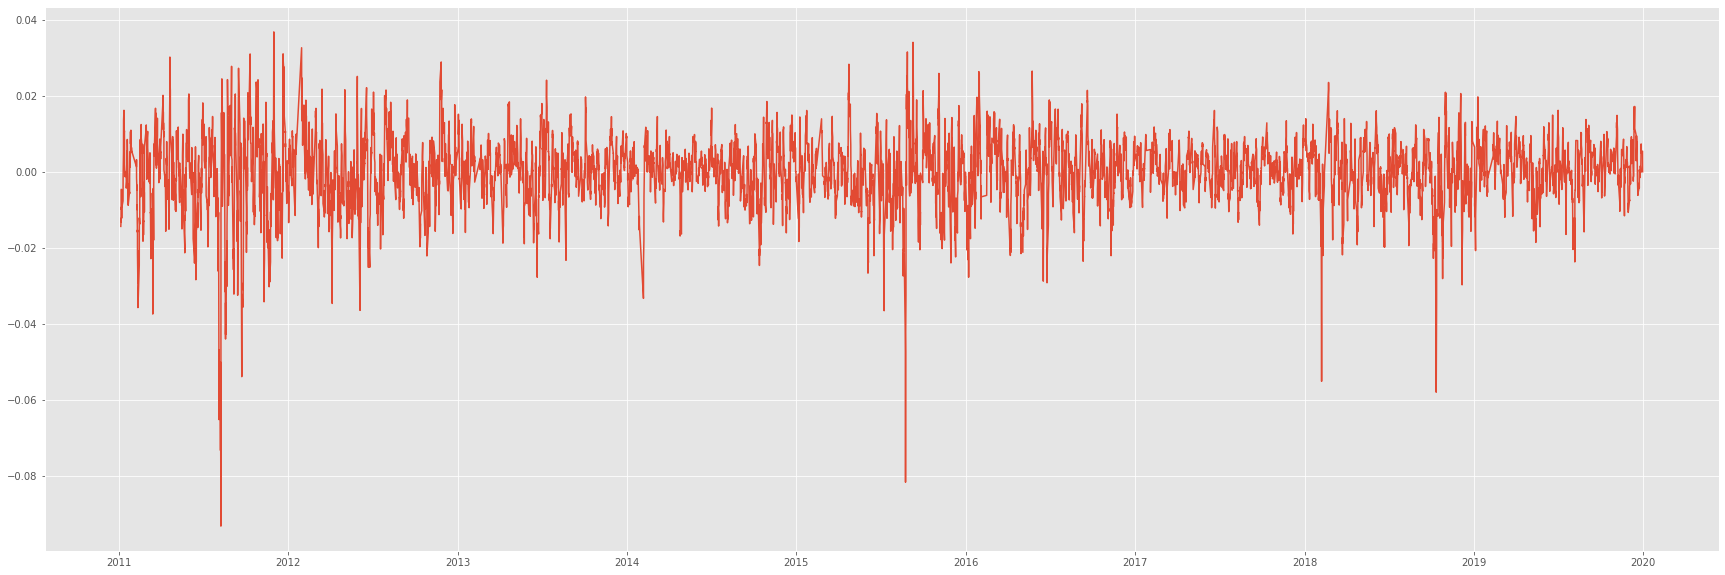

<Figure size 432x288 with 0 Axes>

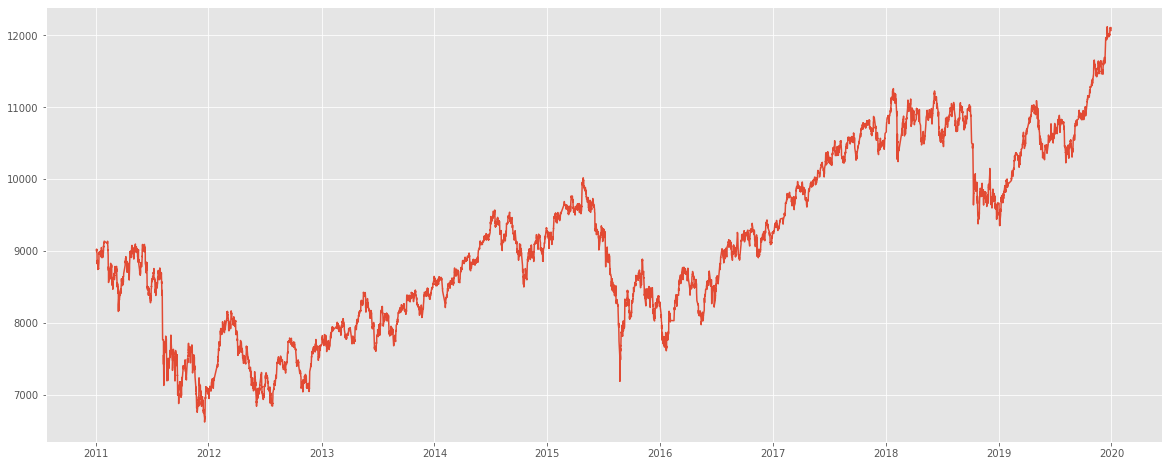

In [ ]:
trainData['nor']= ((trainData['close']-trainData['MA15'])/trainData['MA15'])
plt.figure(figsize = (30,10))
plt.plot(trainData['nor'])
plt.figure()
plt.figure(figsize = (20,8))
plt.plot(trainData['close'])
plt.show()

In [ ]:
settlementDate_= pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/結算日/settlementDate.txt")


settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

,settlementDate,futures,settlementPrice
0,2022/08/03,202208W1,14707
1,2022/07/27,202207W4,14887
2,2022/07/20,202207,14713
3,2022/07/13,202207W2,14384
4,2022/07/06,202207W1,14015
...,...,...,...
508,2009/12/16,200912,7752
509,2009/11/18,200911,7786
510,2009/10/21,200910,7705
511,2009/09/16,200909,7445


In [ ]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]
bool_

[False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False

In [ ]:
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]

In [ ]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]
BS = None

In [ ]:
trainData

,open,high,low,close,volume,Hour,MA,nSTD,STD,MA200,upLine,downLine,MA15,MA180,nSTD180,sb,STD180,diff,nor
2011-01-03 08:45:00,9000.0,9029.0,8995.0,9005.0,20508,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03 09:45:00,9005.0,9014.0,8997.0,9011.0,9022,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03 10:45:00,9010.0,9030.0,9010.0,9023.0,12537,10,9013.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03 11:45:00,9024.0,9026.0,9014.0,9017.0,7529,11,9017.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03 12:45:00,9016.0,9024.0,9009.0,9019.0,11769,12,9019.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 08:45:00,12091.0,12125.0,12080.0,12110.0,24685,8,12101.000000,47.968661,0.003964,12022.666667,12094.619658,11950.713675,12043.466667,12022.666667,12019.166667,-3.500000,0.999709,1.900000,0.005524
2019-12-30 09:45:00,12110.0,12112.0,12076.0,12097.0,13297,9,12101.333333,47.999053,0.003966,12025.266667,12097.265246,11953.268087,12050.266667,12025.266667,12022.155556,-3.111111,0.999741,-1.533333,0.003878
2019-12-30 10:45:00,12096.0,12108.0,12089.0,12104.0,6348,10,12103.666667,46.359187,0.003830,12027.933333,12097.472114,11958.394552,12057.533333,12027.933333,12025.288889,-2.644444,0.999780,0.066667,0.003854
2019-12-30 11:45:00,12103.0,12110.0,12099.0,12107.0,3898,11,12102.666667,42.984405,0.003552,12031.333333,12095.809941,11966.856726,12064.600000,12031.333333,12028.177778,-3.155556,0.999738,0.733333,0.003514


                       profit  profitfee
2011-01-03 08:45:00       0.0        0.0
2011-01-03 09:45:00       0.0        0.0
2011-01-03 10:45:00       0.0        0.0
2011-01-03 11:45:00       0.0        0.0
2011-01-03 12:45:00       0.0        0.0
...                       ...        ...
2019-12-30 08:45:00  879800.0   482600.0
2019-12-30 09:45:00  883600.0   486400.0
2019-12-30 10:45:00  880800.0   482400.0
2019-12-30 11:45:00  880800.0   482400.0
2019-12-30 12:45:00  881800.0   482200.0

[11050 rows x 2 columns]
333
0


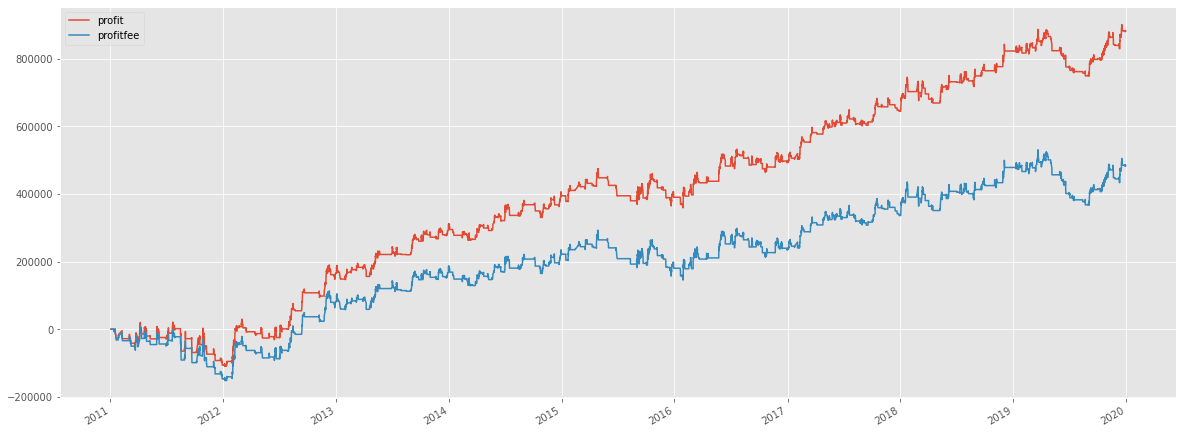

In [ ]:
for k in range(1): 
  BS = None
  buy = []
  sell = []
  sellshort = []
  buytocover = []
  profit_list = [0]
  profit_fee_list = [0]
  profit_fee_list_realized = []
  K=0.06
  entrySellShort= None
  for i in range(len(df_arr)):

      if i == len(df_arr)-1:
          break
          
      ## 進場邏輯
      entryLong = df_arr[i,3] > df_arr[i,10] and df_arr[i,-4] < 0 and df_arr[i,-1] > 0.0001*28
      
      #entrySellShort =  df_arr[i,-4] > 0 and df_arr[i,-1] < -0.02 and df_arr[i,-4] > 0

      #df_arr[i,3] < df_arr[i,11]





      entryCondition = date_arr[i] not in settlementDate
      
      ## 出場邏輯
      exitShort = df_arr[i,3] <= df_arr[i,10]
      exitBuyToCover = df_arr[i,3] >= df_arr[i,11]
      exitCondition = date_arr[i] in settlementDate 
      
      ## 停利停損邏輯
      if BS == 'B':
          stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
          stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
      elif BS == 'S':
          stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
          stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

  #     if exitCondition == True:
  #         print(f'{time_arr[i]}')

      if BS == None:
          profit_list.append(0)
          profit_fee_list.append(0)
          
          if entryLong and entryCondition:
              BS = 'B'
              t = i+1
              buy.append(t)

          elif entrySellShort and entryCondition:
              BS = 'S'
              t = i+1
              sellshort.append(t)
              
      elif BS == 'B':
          profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
          profit_list.append(profit)
              
          if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
              pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
              profit_fee = profit - feePaid*2
              profit_fee_list.append(profit_fee)
              sell.append(i+1)
              BS=None
              
              # Realized PnL
              profit_fee_realized = pl_round - feePaid*2
              profit_fee_list_realized.append(profit_fee_realized)
              
          else:
              profit_fee = profit
              profit_fee_list.append(profit_fee)
              
      elif BS == 'S': 
          profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
          profit_list.append(profit)
          
          if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
              pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
              profit_fee = profit - feePaid*2
              profit_fee_list.append(profit_fee)
              buytocover.append(i+1)
              BS=None
              
              # Realized PnL
              profit_fee_realized = pl_round - feePaid*2
              profit_fee_list_realized.append(profit_fee_realized)
  
          else:
              profit_fee = profit
              profit_fee_list.append(profit_fee)
              
              
  equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
  print(equity)
  print(len(buy))
  print(len(sellshort))
  equity.plot(grid=True, figsize=(20,8));

In [ ]:
nequity=equity

In [ ]:
nequity['equity'] = nequity['profitfee'] + fund
nequity['drawdown_percent'] = (nequity['equity'] / nequity['equity'].cummax()) - 1
nequity['drawdown'] = nequity['equity'] - nequity['equity'].cummax()

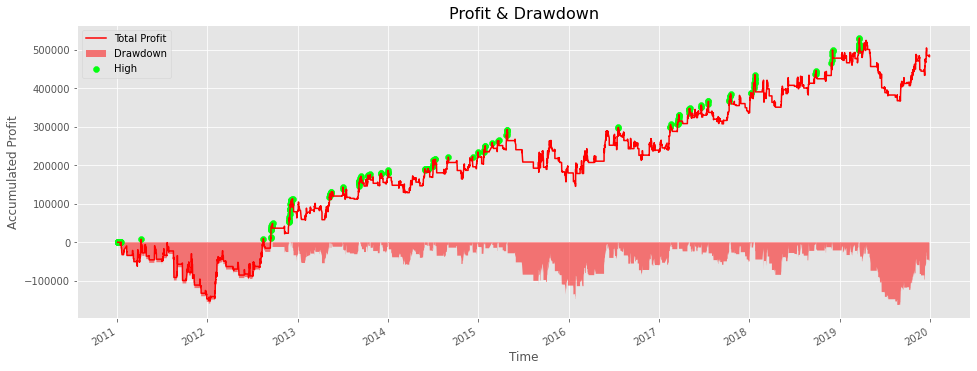

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = nequity[nequity['profitfee'].cummax() == nequity['profitfee']].index
nequity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(nequity['drawdown'].index, nequity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, nequity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);


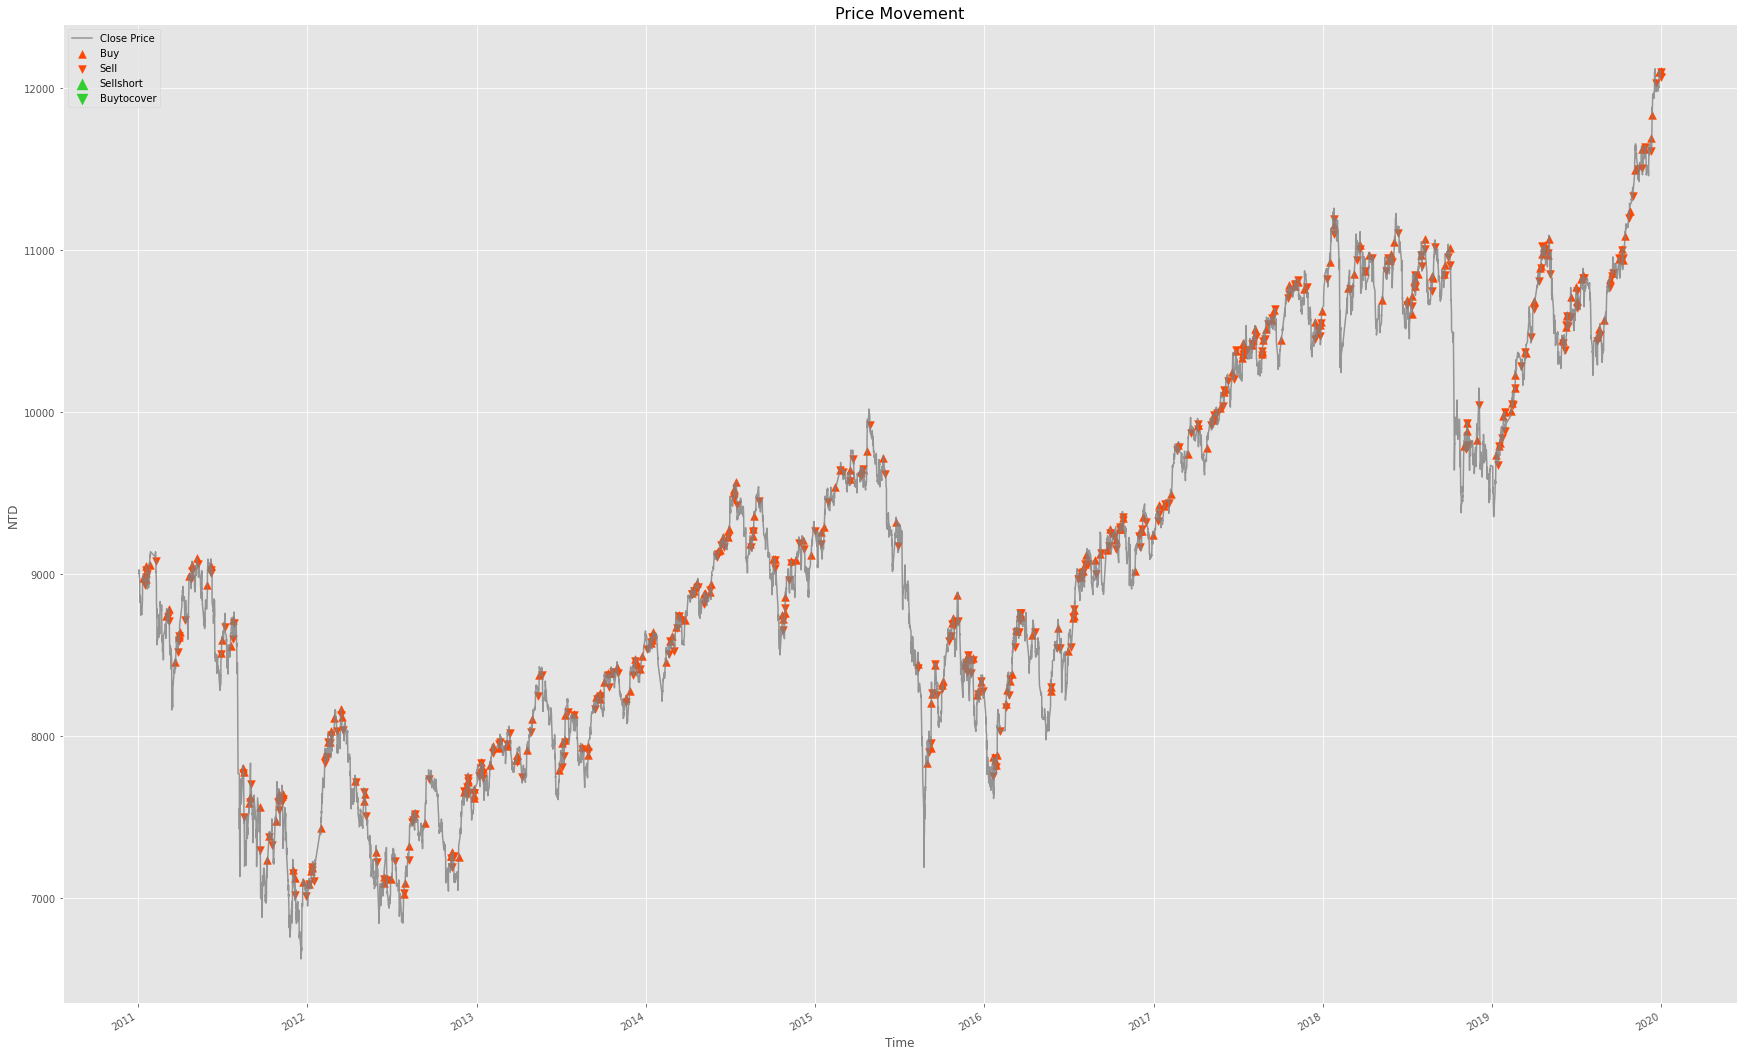

In [ ]:
fig, ax = plt.subplots(figsize = (30,20))

trainData['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(trainData['close'].iloc[buy].index, trainData['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(trainData['close'].iloc[sell].index, trainData['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(trainData['close'].iloc[sellshort].index, trainData['close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='^', s=120)
plt.scatter(trainData['close'].iloc[buytocover].index, trainData['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='v', s=120)

plt.legend()
plt.ylabel('NTD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [ ]:
nprofit_fee_list_realized = profit_fee_list_realized

In [ ]:
profit = nequity['profitfee'].iloc[-1]
ret = nequity['equity'][-1]/nequity['equity'][0] - 1
mdd = abs(nequity['drawdown_percent'].min())
calmarRatio = ret / mdd/10
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in nprofit_fee_list_realized if i > 0]) / len(nprofit_fee_list_realized)
profitFactor = sum([i for i in nprofit_fee_list_realized if i > 0]) / abs(sum([i for i in nprofit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in nprofit_fee_list_realized if i > 0]) / abs(np.mean([i for i in nprofit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $482200.0
return: 48.22%
mdd: 15.9%
calmarRatio: 0.3
tradeTimes: 333
winRate: 38.440000000000005%
profitFactor: 1.28
winLossRatio: 2.02


In [ ]:
#凱利公式
#ATR
#用arctan設定在一定範圍內的指數
#蒙第卡羅模擬
#凱勒通道
#慣性加速度策略,往下用力打的時間也短,但慢慢來的時間也長,說不定相乘式定值
#找相關係數大的hedge
#0050根台指的期限套利
#用vix跟卷值比
#putcall ratio 和 EMA